In [1]:
###数据读取并分割
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
df = pd.read_csv('Dataset.csv')
# 划分特征和目标变量
X = df.drop(['target'], axis=1)
y = df['target']
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=df['target'])
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,1,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,0,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,2,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,0,0


In [2]:
###模型构建
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# XGBoost模型参数
params_xgb = {
    'learning_rate': 0.02,            # 学习率，控制每一步的步长，用于防止过拟合。典型值范围：0.01 - 0.1
    'booster': 'gbtree',              # 提升方法，这里使用梯度提升树（Gradient Boosting Tree）
    'objective': 'binary:logistic',   # 损失函数，这里使用逻辑回归，用于二分类任务
    'max_leaves': 127,                # 每棵树的叶子节点数量，控制模型复杂度。较大值可以提高模型复杂度但可能导致过拟合
    'verbosity': 1,                   # 控制 XGBoost 输出信息的详细程度，0表示无输出，1表示输出进度信息
    'seed': 42,                       # 随机种子，用于重现模型的结果
    'nthread': -1,                    # 并行运算的线程数量，-1表示使用所有可用的CPU核心
    'colsample_bytree': 0.6,          # 每棵树随机选择的特征比例，用于增加模型的泛化能力
    'subsample': 0.7,                 # 每次迭代时随机选择的样本比例，用于增加模型的泛化能力
    'eval_metric': 'logloss'          # 评价指标，这里使用对数损失（logloss）
}


# 初始化XGBoost分类模型
model_xgb = xgb.XGBClassifier(**params_xgb)


# 定义参数网格，用于网格搜索
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],  # 树的数量
    'max_depth': [3, 4, 5, 6, 7],               # 树的深度
    'learning_rate': [0.01, 0.02, 0.05, 0.1],   # 学习率
}


# 使用GridSearchCV进行网格搜索和k折交叉验证
grid_search = GridSearchCV(
    estimator=model_xgb,
    param_grid=param_grid,
    scoring='neg_log_loss',  # 评价指标为负对数损失
    cv=5,                    # 5折交叉验证
    n_jobs=-1,               # 并行计算
    verbose=1                # 输出详细进度信息
)

# 训练模型
grid_search.fit(X_train, y_train)

# 输出最优参数
print("Best parameters found: ", grid_search.best_params_)
print("Best Log Loss score: ", -grid_search.best_score_)

# 使用最优参数训练模型
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
Best Log Loss score:  0.40727758351836074


In [3]:
###模型评价
from sklearn.metrics import classification_report
# 预测测试集
y_pred = best_model.predict(X_test)
# 输出模型报告， 查看评价指标
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88        32
           1       0.88      0.82      0.85        28

    accuracy                           0.87        60
   macro avg       0.87      0.86      0.87        60
weighted avg       0.87      0.87      0.87        60



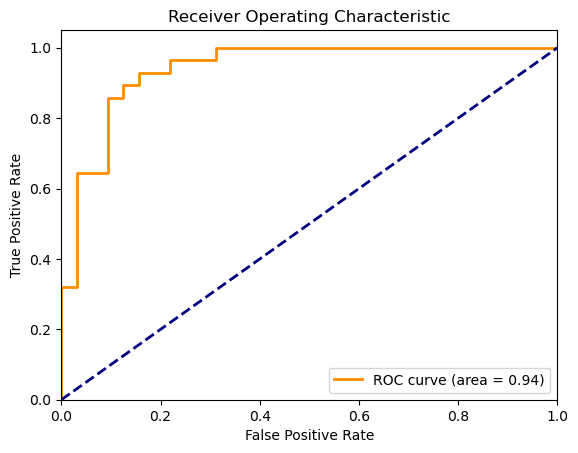

In [4]:
###ROC曲线
from sklearn.metrics import roc_curve, auc
# 预测概率
y_score = best_model.predict_proba(X_test)[:, 1]
# 计算ROC曲线
fpr_logistic, tpr_logistic, _ = roc_curve(y_test, y_score)
roc_auc_logistic = auc(fpr_logistic, tpr_logistic)
# 绘制ROC曲线
plt.figure()
plt.plot(fpr_logistic, tpr_logistic, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_logistic)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [5]:
###模型保存
import joblib
# 保存模型
joblib.dump(best_model , 'XGBoost.pkl')

['XGBoost.pkl']